<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
"""
@author: LorenzoVisentini
"""

#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#keras
import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
#Images parameters
img_width = 299
img_height = 299

# train_dir = './source_light/training'
# validation_dir = './source_light/validation' 
train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/training'
validation_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/validation' 


In [14]:
#from https://edebrouwer.github.io/deeplearning/carvision/transfer/neural/networks/learning/2017/08/05/TransferLearning.html

#Transfer learning on InceptionV3 model
#use all the layers except for the last fully connected layer (because its 
#specific to the ImageNet competition)
#we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = (img_height, img_width, 3),
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [15]:
n_classes = 3

#transfer learning phase
x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x) #add fully connected layer
x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers
#freeze the model excepted added layers
for layer in pre_trained_model.layers:
    layer.trainable = False

model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [16]:
#preprocessing
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=128,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(directory=validation_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=128,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

Found 7000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [17]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//train_generator.batch_size,
                             epochs = 4,
                             validation_data = val_generator
                             )


Epoch 1/4
54/54 [==============================] - 130s 2s/step - loss: 1.1954 - accuracy: 0.5052 - val_loss: 0.9880 - val_accuracy: 0.5340
Epoch 2/4
54/54 [==============================] - 108s 2s/step - loss: 0.8799 - accuracy: 0.5751 - val_loss: 1.0138 - val_accuracy: 0.5470
Epoch 3/4
54/54 [==============================] - 108s 2s/step - loss: 0.8150 - accuracy: 0.6126 - val_loss: 0.7356 - val_accuracy: 0.5473
Epoch 4/4
54/54 [==============================] - 108s 2s/step - loss: 0.7851 - accuracy: 0.6292 - val_loss: 0.8700 - val_accuracy: 0.5500


In [19]:
import pickle
#save model and history
model.save('/content/drive/My Drive/Deep Learning Project - Image Classification/Models/InceptionV3_batch128epoch4.h5')

with open('/content/drive/My Drive/Deep Learning Project - Image Classification/History/InceptionV3_batch128epoch4.csv', 'wb') as file:
    pickle.dump(history.history, file)


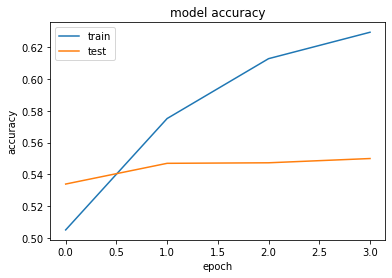

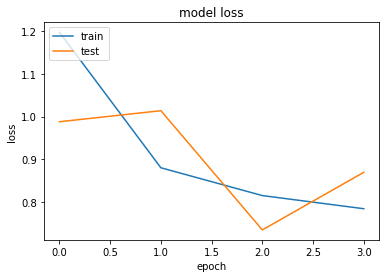

In [20]:
#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = val_generator.n // val_generator.batch_size

accuracy_ontest = model.evaluate_generator(val_generator, steps)
predictions_ontest = model.predict_generator(val_generator, steps)
print(accuracy_ontest)
print(predictions_ontest)

[1.0592540502548218, 0.55027174949646]
[[0.5841574  0.1566183  0.25922427]
 [0.9629712  0.01457125 0.02245747]
 [0.8024894  0.07174213 0.12576847]
 ...
 [0.97526836 0.01103983 0.01369183]
 [0.78922313 0.07468522 0.13609162]
 [0.9137898  0.02703066 0.05917947]]
